In [ ]:
# Dataloading Stuff
from google.colab import drive
from sys import path
import os

# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas pyss3
from sklearn.model_selection import train_test_split
import pyss3
from pyss3 import SS3
from pyss3.util import Dataset, Evaluation, span
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import itertools
import numpy as np
import pandas as pd



In [ ]:
drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab/SingleLabel/'
path.append(path_root)
data_root = 'data/'

/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=59 mode='wb' closefd=True>
  del self._target, self._args, self._kwargs
/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=61 mode='rb' closefd=True>
  del self._target, self._args, self._kwargs


Mounted at /content/drive


In [ ]:
df = pd.read_csv(path_root + data_root + "IMDBReviews/IMDB Dataset.csv", sep=";")
df['review'].replace({'<br />': '\\n'}, inplace=True, regex=True)
df.dropna(inplace=True)
text = df['review'].to_list()
labels = df['sentiment'].to_list()

X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.2)

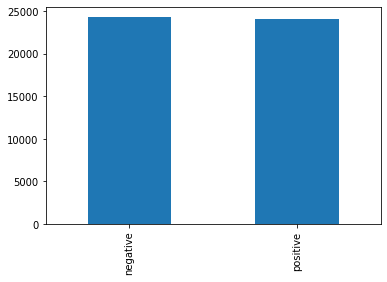

In [ ]:
pd.Series([yy for yy in labels]).value_counts().plot(kind ='bar')

In [ ]:
def binarize_label(y_train):
  data_by_class = {}
  for label in set(y_train):
    data_by_class[label] = [label if x == label else 'other' for x in y_train]
  return data_by_class

In [ ]:
def train_clfs(X_train, y_train):
  clf_by_class = {}
  if isinstance(y_train, dict):
    for key, value in y_train.items():
      clf = SS3(name=key)
      clf.train(X_train, value,n_grams=5)
      clf_by_class[key] = clf
  else:
    print("data per class not found")
  
  return clf_by_class


In [ ]:
def change_parameter(s,l,p,a, clfs):
  for key, value in clfs.items():
    value.set_hyperparameters(s,l,p,a)

In [ ]:
def classify_clfs(data, clfs):
  predict = {}
  if isinstance(clfs, dict):
    for key, value in clfs.items():
      predict[key] = value.predict_proba(data) + [value.get_category_index(key)] 
  else:
    print("clf per class not found")

  return predict


In [ ]:
def predicted(predicted_clfs, iterations):
  predicted = []
  for i in range(iterations):
    last_value = 0
    label = ''
    for key, value in predicted_clfs.items():
      score = value[i][value[-1]]
      if score > last_value:
        last_value = score
        label = key
    # print("last_value: ", last_value, " and Label: ", label)
    predicted.append(label)
  return predicted

# **DEFAULT COMPARISON**

In [ ]:
pyss3.set_verbosity(1)
binarized_data = binarize_label(y_train)
clfs = train_clfs(X_train, binarized_data)

Training on 'positive': 100%|██████████| 2/2 [02:54<00:00, 87.32s/it]


In [ ]:
predicted_clfs = classify_clfs(X_val,clfs)
y_pred = predicted(predicted_clfs, len(X_val))

Classification: 100%|██████████| 9693/9693 [01:03<00:00, 152.12it/s]


Macro F1 score :  0.8267459267404687
Micro F1 score:  0.82688538120293
 ------- 


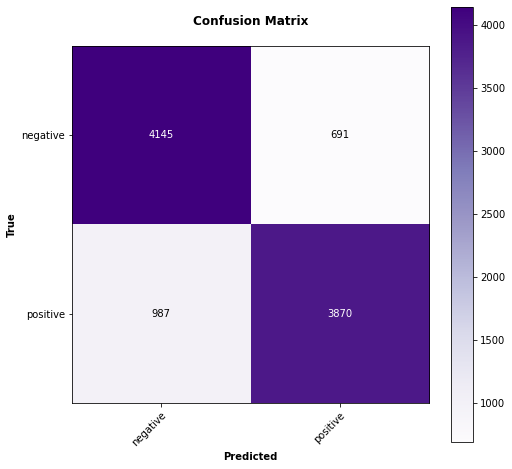

In [ ]:
print("Macro F1 score : " , f1_score(y_val, y_pred, average='macro'))
print("Micro F1 score: " , f1_score(y_val, y_pred, average='micro'))
print(" ------- ")
categories = list(set(labels)) 
# ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred, labels=categories),display_labels=categories).plot(values_format='.1f')
Evaluation.__plot_confusion_matrices__([confusion_matrix(y_val, y_pred, labels=categories)], categories)

Classification: 100%|██████████| 9693/9693 [01:03<00:00, 152.89it/s]



              precision    recall  f1-score   support

    negative       0.82      0.85      0.83      4874
    positive       0.84      0.81      0.82      4819

    accuracy                           0.83      9693
   macro avg       0.83      0.83      0.83      9693
weighted avg       0.83      0.83      0.83      9693


 Accuracy: 0.829

[ updating evaluations cache ]


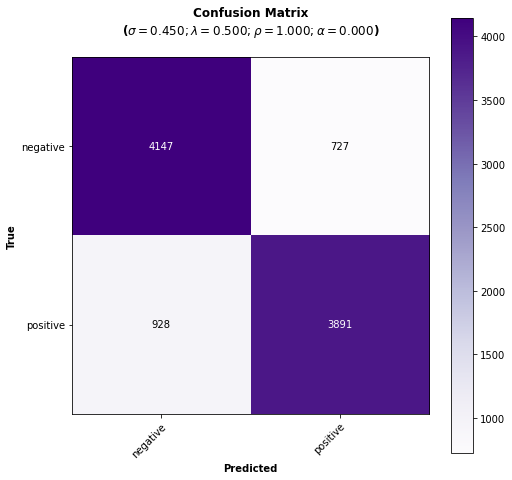

0.8291390467776463

In [ ]:
clf = SS3()
clf.train(X_train, y_train,n_grams=5)
Evaluation.test(clf, X_val, y_val, metric="f1-score", metric_target='micro avg',)

# **GRID SEARCH**

In [ ]:
s=span(0, 1, 11)  # [0.2 , 0.32, 0.44, 0.56, 0.68, 0.8]
l=span(0, 1, 6)   # [0.1 , 0.48, 0.86, 1.24, 1.62, 2]
p=span(0, 1, 6)   # [1.75, 1.95, 2.15, 2.35, 2.55, 2.75]
a=span(0, 5, 6)
slpa = list(itertools.product(s,l,p,a))
iterations = len(slpa)
divider = 50

In [ ]:
pyss3.set_verbosity(0)
current_iteration = 0
last_metric_value = 0
last_metric_value_default = 0
best_y_pred = []
best_y_pred_default = []
for s,l,p,a in slpa:
  current_iteration += 1
  print('\r',current_iteration, end='')

  change_parameter(s,l,p,a,clfs)
  clf.set_hyperparameters(s,l,p,a)
  predicted_clfs = classify_clfs(X_val,clfs)
  y_pred = predicted(predicted_clfs, len(X_val))
  metric_value = f1_score(y_val, y_pred, average='macro')
  if(metric_value > last_metric_value):
    last_metric_value = metric_value
    best_y_pred = y_pred
    best = (s,l,p,a)  
  
  clf.set_hyperparameters(s,l,p,a)
  y_pred_default = clf.predict(X_val)
  metric_value_default = f1_score(y_val, y_pred_default, average='macro')
  if(metric_value_default > last_metric_value_default):
    last_metric_value_default = metric_value_default
    best_y_pred_default = y_pred_default
    best_default = (s,l,p,a)   

  if(current_iteration%divider == 0):
    print(' -> best value so far: ', last_metric_value, ' -> best values: s={}, l={}, p={}, a={}'.format(best[0], best[1], best[2], best[3]), "iterations: ", current_iteration, "/", iterations)
    print(' -> best value so far: ', last_metric_value_default, ' -> best values: s={}, l={}, p={}, a={}'.format(best_default[0], best_default[1], best_default[2], best_default[3]), "iterations: ", current_iteration, "/", iterations)
    print('------------------------')

 12

KeyboardInterrupt: ignored

In [ ]:
print("F1 score micro: " , f1_score(y_val, best_y_pred, average='micro'))
print("F1 score macro: " , f1_score(y_val, best_y_pred, average='macro'))
print(" ------- ")
categories = list(set(labels)) 
ConfusionMatrixDisplay(confusion_matrix(y_val, best_y_pred, labels=categories),display_labels=categories).plot(values_format='.1f')

In [ ]:
clf.set_hyperparameters(s=best_default[0], l=best_default[1], p=best_default[2], a=best_default[3])
Evaluation.test(clf, X_val, y_val)